In [36]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
from construct_phase_gs import PhaseGS
from im_postprocess import PostProcess
import config


In [37]:
from IPython.display import FileLink

FileLink("MNIST_phase_init.pt")

phase_init = torch.load("MNIST_phase_init.pt", map_location="cpu")
print("Initial phase shape:", phase_init.shape)

Initial phase shape: torch.Size([16, 255, 255])


In [38]:
import torch
from torchvision.datasets import MNIST


ds = MNIST(root="./data", train=True, download=False)

N_batch = 10
idx0 = 111   # starting index

objs = []
labels = []
for i in range(N_batch):
    x_pil, y = ds[idx0 + i]
    objs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
    labels.append(y)

objs = torch.stack(objs, dim=0)   # [N,28,28]

print("Loaded batch:", objs.shape)
print("Labels (first 10):", labels[:10])


Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


imgs shape: torch.Size([10, 16, 28, 28])


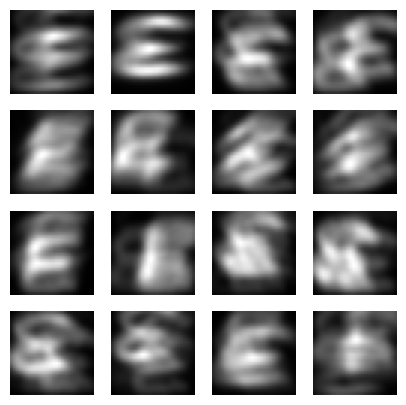

In [39]:
from full_opt_forward import FullOptForward

asm = ASMPropagator(config)
phase = PhaseMask(
    config,
    init="custom",
    custom=phase_init,
    X=asm.X,
    Y=asm.Y,    
)
pm = PixelMap(config, asm.X, asm.Y)
conv = PSFConv(config, pm, asm.X, asm.Y)

model = FullOptForward(config, phase, asm, pm, conv)
imgs = model.image_forward(objs)

pp = PostProcess(config, pixel_map=pm, X=asm.X, Y=asm.Y)
imgs = pp(imgs)

print("imgs shape:", imgs.shape)

x = imgs[0].detach().cpu()  # [16, 255, 255]

fig, ax = plt.subplots(4, 4, figsize=(5, 5))
for i, a in enumerate(ax.flat):
    a.imshow(x[i].T, cmap="gray", origin="lower")
    a.axis("off")
plt.show()

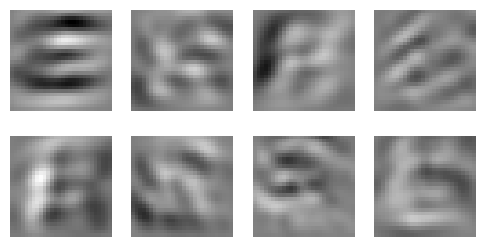

In [40]:
diffs = x[0::2] - x[1::2]   
v = diffs.abs().max()
fig, ax = plt.subplots(2, 4, figsize=(6, 3))
for i, a in enumerate(ax.flat):
    a.imshow(diffs[i].T, cmap="gray", origin="lower", vmin=-v, vmax=v)
    # a.set_title(i, fontsize=8)
    a.axis("off")
plt.show()

In [41]:
# Full imaging forward

asm = ASMPropagator(config)

phase = PhaseMask(
    config,
    init="custom",
    custom=phase_init,
    X=asm.X,
    Y=asm.Y,    
)

psfs, _ = asm(phase_mask=phase, normalize=True, return_field=True)

pm = PixelMap(config, asm.X, asm.Y)
conv = PSFConv(config, pm, asm.X, asm.Y)

imgs = conv.sensor_image(objs, psfs)

print(imgs.shape)


torch.Size([10, 16, 255, 255])


torch.Size([16, 255, 255])


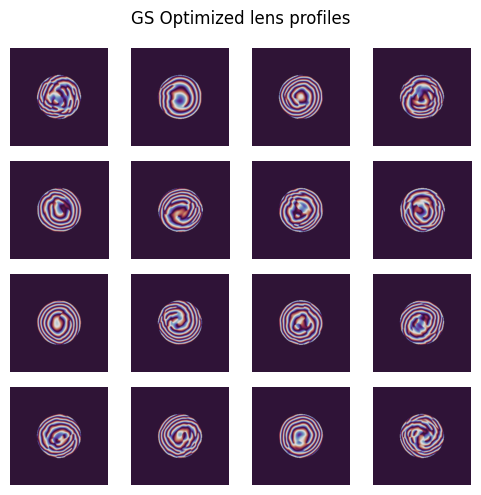

In [42]:
asm = ASMPropagator(config)

phase = PhaseMask(
    config,
    init="custom",
    custom=phase_init,
    X=asm.X,
    Y=asm.Y,    
)

print(phase.phi.shape)

phi = phase.phi.detach().cpu()
fig, ax = plt.subplots(4, 4, figsize=(5, 5))
for i, a in enumerate(ax.flat):
    im = a.imshow(phi[i], cmap="twilight", origin="lower")
    # a.set_title(i, fontsize=8)
    a.axis("off")

fig.suptitle('GS Optimized lens profiles')

plt.tight_layout()
plt.show()

torch.Size([16, 255, 255])
torch.Size([16, 255, 255])


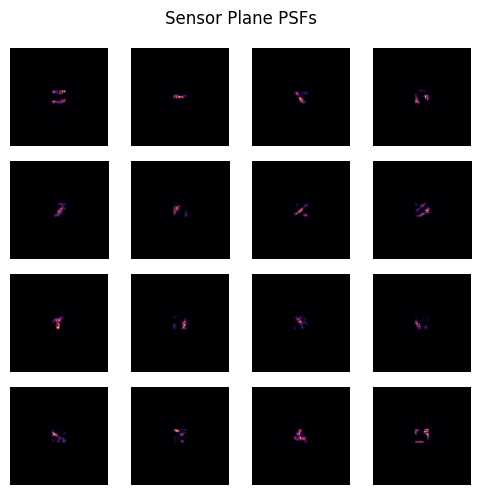

In [43]:
psfs, Uz = asm(phase_mask=phase, normalize=True, return_field=True)

print(Uz.shape)
print(psfs.shape)

psfs = psfs.detach().cpu()
fig, ax = plt.subplots(4, 4, figsize=(5, 5))
for i, a in enumerate(ax.flat):
    im = a.imshow(psfs[i].T, cmap="inferno", origin="lower")
    # a.set_title(i, fontsize=8)
    a.axis("off")

fig.suptitle('Sensor Plane PSFs')

plt.tight_layout()
plt.show()

In [44]:
pm = PixelMap(config, asm.X, asm.Y)

conv = PSFConv(config, pm, asm.X, asm.Y)

imgs = conv.sensor_image(objs, psfs)

print(imgs.shape)

torch.Size([10, 16, 255, 255])


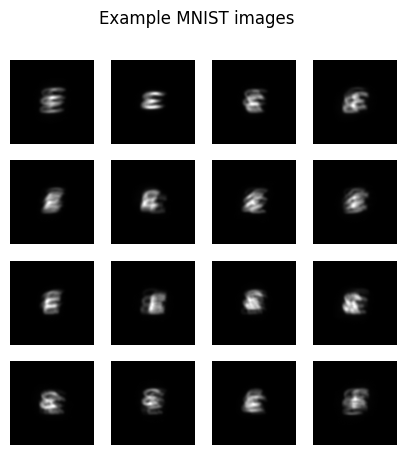

In [45]:

x = imgs[0].detach().cpu()  # [16, 255, 255]

fig, ax = plt.subplots(4, 4, figsize=(5, 5))
for i, a in enumerate(ax.flat):
    a.imshow(x[i].T, cmap="gray", origin="lower")
    a.axis("off")
    
fig.suptitle('Example MNIST images')
plt.show()


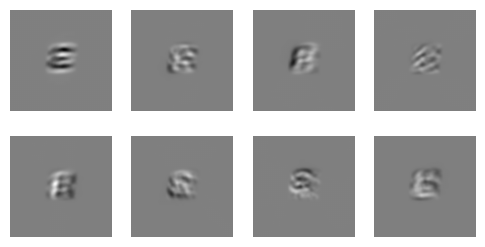

In [46]:
diffs = x[0::2] - x[1::2]   
v = diffs.abs().max()
fig, ax = plt.subplots(2, 4, figsize=(6, 3))
for i, a in enumerate(ax.flat):
    a.imshow(diffs[i].T, cmap="gray", origin="lower", vmin=-v, vmax=v)
    # a.set_title(i, fontsize=8)
    a.axis("off")
plt.show()